In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mapping to/from integers
# chars = 
# stoi =
# itos =
# vocab_size =

chars = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars,1)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)


# chars = sorted(list(set(''.join(words))))
# stoi = {s:i+1 for i,s in enumerate(chars)}
# stoi['.'] = 0
# itos = {i+1:s for i,s in enumerate(chars)}
# itos[0] = '.'
# vocab_size = len(itos)


print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset 
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([205280, 3]) torch.Size([205280])
torch.Size([22866, 3]) torch.Size([22866])


In [49]:
# MPL revisited
n_embd = 10  # the dimensionality of the character embedding vector
n_hidden = 200  # the number of neurons in the hidden layer of the MPL

g  = torch.Generator().manual_seed(2147483647)  # for reproductibility
C  = torch.randn((vocab_size, n_embd),            generator= g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator= g) * ((5 / 3) / ( (n_embd * block_size)**0.5 ) )  #0.2    #so that matrix multiplication for one sample becomes sum(features * weights)
#b1 = torch.randn(n_hidden,                        generator= g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),           generator= g) * 0.01   #why not 0?
b2 = torch.randn(vocab_size,                      generator= g) * 0      #at initiallization

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
#two bufferes, these are not training with back propagation 
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # no. of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [7]:
torch.randn(1000).std()

tensor(1.0240)

tensor(0.0003) tensor(0.9933)
tensor(0.0015) tensor(0.9999)


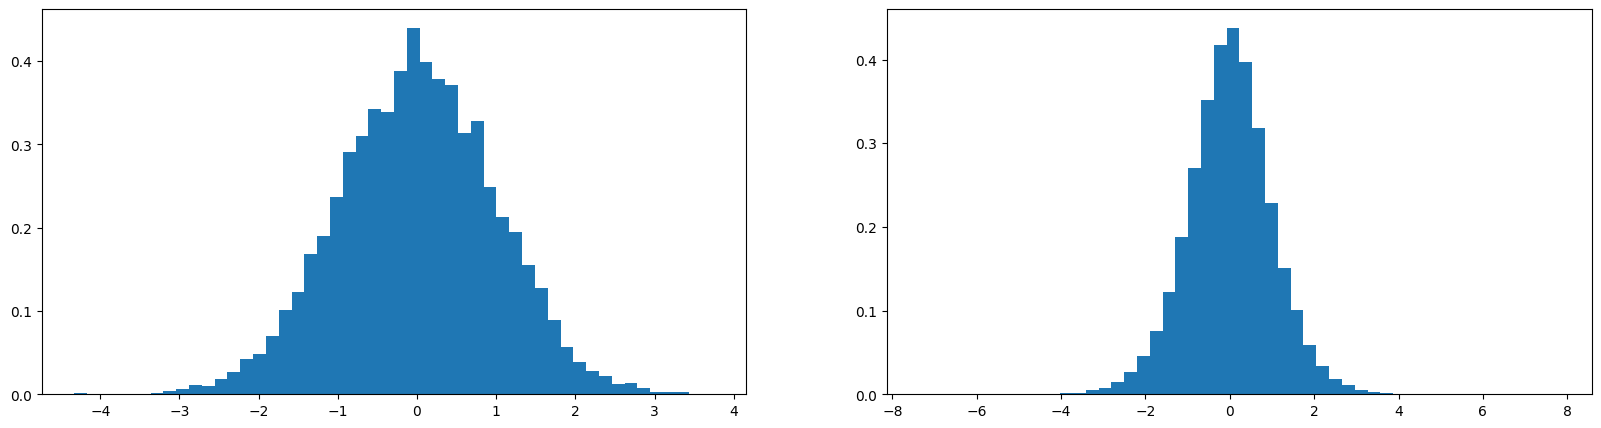

In [8]:
tan_std = (5 / 3) / (10**0.5)  #for tanh
std = 1 / 10**0.5

x = torch.randn(1000, 10)
w = torch.randn(10, 200) * std   # / 10**0.5 #square root of fan_in
y = x @ w
t = torch.tanh(y)
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

In [31]:
hpreact.shape

torch.Size([32, 200])

In [32]:
hpreact.mean(0, keepdim = True).shape

torch.Size([1, 200])

In [33]:
hpreact.std(0, keepdim = True).shape

torch.Size([1, 200])

In [50]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  #batch X,Y

    #forward pass
    emb = C[Xb]  #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  #concatenate the vetors

    #linear layer
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
    # bcz of substraction b1 bias not having any influence # it will not learn

    #BatchNorm layer
    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    # normalization of batch
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi) + bnbias  #bnbias -> now this is main incharge of biasness
    # what it will do that every single neuron now and its firing rate will be exactly unit Gaussian on these 32 examples of batch
    # if you think first hpreact is giving activations and logits for the example and then it suddenly evaluating it through all of other examples of batch
    # we introduced noice in it, so acc to other examples now it will jitter little bit and change it self
    # which will protect him from overfitting , so that it will not fit with exact example
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # non-linearity
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2  #output layer
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 #step learning rate decav
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:   #print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    
    #break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


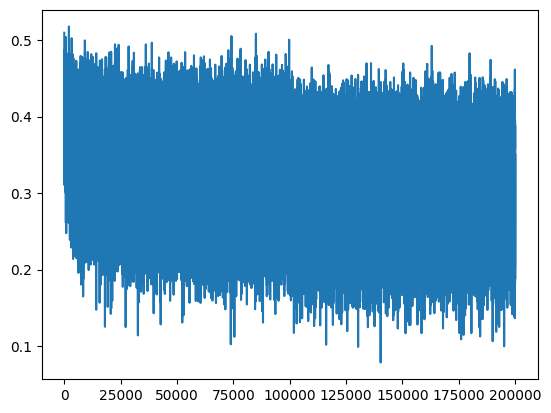

In [28]:
plt.plot(lossi)

In [51]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean / std over the entire training set
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)
    

In [52]:
bnmean

tensor([[-2.3355,  0.6776, -0.9133,  1.0163,  1.0866,  1.0938,  1.7437, -2.1208,
          0.5730,  1.4455, -1.6343, -2.7372, -0.4752, -0.1412, -0.0746, -1.1722,
          0.6851, -2.6219, -0.1065,  1.6326, -0.7706, -0.3063,  0.0479,  0.6115,
          1.1173,  0.2427,  2.0500,  0.5831,  0.8527,  1.7680, -0.3625, -0.8356,
         -0.0854, -0.5177, -0.3806, -1.0698, -0.0786,  0.3487, -0.5808,  0.9875,
         -0.4427, -1.3082, -0.2871, -0.2332,  0.6850,  0.6850,  2.0857, -0.7608,
          2.3866,  1.8734,  0.8259,  0.2803,  1.8897,  0.4709,  0.6739, -1.8940,
         -0.0401,  0.4338,  1.3760, -0.8910, -0.4524,  1.1754,  0.5613,  0.6051,
          1.5858,  1.2261, -1.0111,  2.1495, -0.6392,  0.0938, -0.2864, -0.4856,
          0.9632, -1.0461, -2.9990,  0.6391,  1.4327, -0.1590,  0.0941,  0.5253,
          0.2508,  1.2521,  2.0389,  0.6608,  0.0691, -0.0813, -1.6723,  0.2933,
          2.2423, -0.0210, -0.6666,  1.4253, -0.8412, -1.2248, -1.0129,  0.2230,
          0.2113, -0.3226,  

In [53]:
bnmean_running

tensor([[-2.3539,  0.6872, -0.9000,  1.0159,  1.0894,  1.0862,  1.7389, -2.1357,
          0.5608,  1.4246, -1.6445, -2.7426, -0.4861, -0.1510, -0.0687, -1.1550,
          0.6891, -2.6399, -0.1283,  1.6241, -0.7732, -0.2865,  0.0467,  0.6119,
          1.1172,  0.2433,  2.0542,  0.5778,  0.8515,  1.7729, -0.3741, -0.8386,
         -0.0831, -0.5198, -0.3817, -1.0698, -0.0780,  0.3370, -0.5768,  0.9935,
         -0.4507, -1.3313, -0.2895, -0.2299,  0.6877,  0.6936,  2.0835, -0.7759,
          2.3804,  1.8613,  0.8117,  0.2735,  1.8802,  0.4704,  0.6656, -1.8962,
         -0.0420,  0.4356,  1.3924, -0.8906, -0.4676,  1.1688,  0.5539,  0.6001,
          1.5853,  1.2103, -1.0171,  2.1422, -0.6330,  0.1071, -0.2926, -0.4831,
          0.9506, -1.0144, -2.9925,  0.6269,  1.4404, -0.1574,  0.0955,  0.5159,
          0.2487,  1.2401,  2.0104,  0.6695,  0.0768, -0.0851, -1.6767,  0.2964,
          2.2374, -0.0100, -0.6669,  1.4356, -0.8431, -1.2317, -1.0221,  0.2201,
          0.1928, -0.3261,  

In [55]:
@torch.no_grad()  #this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val':   (Xdev, Ydev),
        'test':  (Xte, Yte),
    }[split]
    emb = C[x]   #(samples, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  #concat into (samples, block_size*n_embd)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True)) / (hpreact.std(0, keepdim = True)) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running) + bnbias
    h = torch.tanh(hpreact)  #(samples, n_hidden)
    logits = h @ W2 + b2  #(samples, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.0708370208740234


In [38]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size #initialize with all ...
    while True:
        #forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  #decode and print the generated word

carpahzarbriq.
shlimrixtts.
lusslaysierricnenddhn.
frtivgqliyah.
farrichaiirdnsleggyu.
bmanvitte.
sants.
lustvi.
vabbuwatth.
giidryxiidh.
sulipsables.
falia.
gtas.
jasfaylahas.
bduricsydustquovozswy.
bjumillassannyks.
sadlusoffordst.
sramsryndlycpllmanraq.
shelseombriyabhda.
ffxrdustvebndvi.


In [ ]:
h
#so tanh what it do is squeeze the data in range of -1 to 1
#we are seeing so many values of -1 and 1
#lets see through plt

In [20]:
h.shape

torch.Size([32, 200])

In [21]:
h.view(-1).shape

torch.Size([6400])

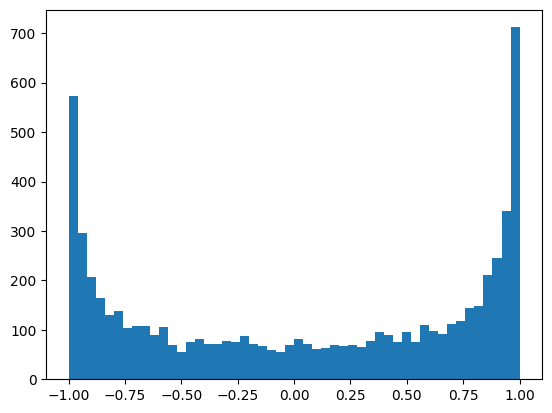

In [22]:
plt.hist(h.view(-1).tolist(), 50);
# it is a problem because we know the graph of tanh flatterns at -1 & 1
# also you can see from grad formula = 1-tanh**2, which makes grad = 0
# which means it didn't backpropogate -> it stops back propogating
# which makes the grad = 0 and never improving or learning
# that makes the dead neurons and a permanent brain damage
# and which mean their is is less trainnig for those neurons 
# bcz they update less frequently
# not good specially at initiallization
# also it is a problem of scaling and wide range
# we found in main code -> hpreact = embcat @ W1 + b1
# and here W1 and b1 is causing the issue
# so we want this reactivation closer to zero
# not exactly zero , sometimes it is improves little bit optimization
# so that their is like a little bit variation and diversity in the original initiallization of neurons

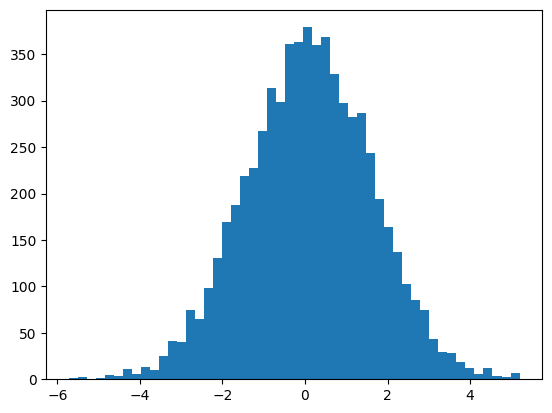

In [23]:
# so let see why that is
# so we can see that the distribution of pre-activations is very very broad
plt.hist(hpreact.view(-1).tolist(), 50);

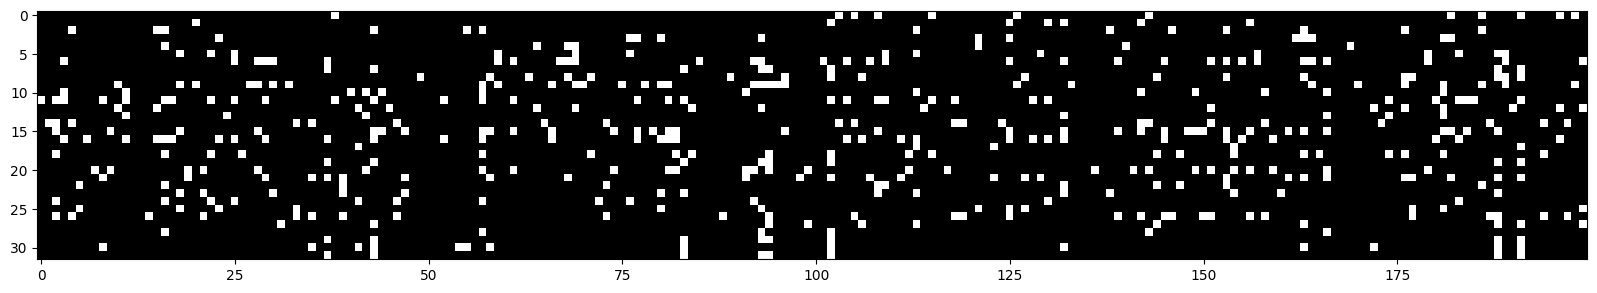

In [24]:
plt.figure(figsize=(20,10))
plt.show(plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest'))
# it is showing how many neurons are dead which is too many
# white -> dead neurons

In [25]:
logits[0]
#range is big  #loss at initialization is much

tensor([-0.0521,  0.2584, -0.0805,  0.0368,  0.1352, -0.0441, -0.0346, -0.0126,
        -0.0057,  0.0850,  0.1718, -0.0434,  0.0048, -0.1928, -0.0810,  0.0371,
        -0.0075, -0.1335, -0.2473, -0.0259,  0.1766,  0.1179,  0.1208, -0.0968,
        -0.1705,  0.1070,  0.1170], grad_fn=<SelectBackward0>)

In [ ]:
# 4-dimensional example of the issue
#logits = torch.tensor([0.0,0.0,0.0,0.0]) normally distributed #loss-> 0.25
# also randn is normally distributed like this 
# but what if we scale it by multiplying or adding 
# it increases the range of logit 
logits = torch.randn(4) * 10  
# we found in main code logits = h @ W2 + b2
# and here b2 and W2 is found out to be responsible for scaling
# so we need to initiallize them as small as possible
# so we should do b2 = 0 at initiallization
# and W2 as small possible not exactly zero
# so that the loss will come more close to normalize distribution (-torch.tensor(1/27.0).log())
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

In [26]:
# at initiallizaation we expect much less loss or u can say noramlly distributed loss
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [ ]:
# import matplotlib
# print(matplotlib.get_backend())